<a href="https://colab.research.google.com/github/Childishs/lets-biat-cancer/blob/main/PartOne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import seaborn as sns

dataset_id = 77
dataset = openml.datasets.get_dataset(dataset_id)
csv_filename = "dataset_breast_cancer.csv"
X, y, _, _ = dataset.get_data(dataset_format="dataframe")
df = pd.concat([X, y], axis=1)
df.to_csv(csv_filename, index=False)


In [202]:
cancer_breast = pd.read_csv('dataset_breast_cancer.csv')
cancer_breast.head()
cancer_breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   age          1000000 non-null  object
 1   menopause    1000000 non-null  object
 2   tumor-size   1000000 non-null  object
 3   inv-nodes    1000000 non-null  object
 4   node-caps    1000000 non-null  object
 5   deg-malig    1000000 non-null  int64 
 6   breast       1000000 non-null  object
 7   breast-quad  1000000 non-null  object
 8   irradiat     1000000 non-null  object
 9   Class        1000000 non-null  object
dtypes: int64(1), object(9)
memory usage: 76.3+ MB


In [203]:
nb_instances = cancer_breast.shape[0]
nb_features = cancer_breast.shape[1]
feature_types = cancer_breast.dtypes

print("Nombre d'instances : ", nb_instances)
print("Nombre de features : ", nb_features)
print(feature_types.value_counts())


Nombre d'instances :  1000000
Nombre de features :  10
object    9
int64     1
Name: count, dtype: int64


In [204]:
nb_nulls = cancer_breast.isnull().sum()
total_nulls = cancer_breast.isnull().sum().sum()

print("Nombre de valeurs nulles par colonne :")
print(nb_nulls)
print(f"Total des valeurs nulles : {total_nulls}")

Nombre de valeurs nulles par colonne :
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64
Total des valeurs nulles : 0


Etant donné qu'aucune donnée n'est manquante dans notre dataset, nous pouvons continuer notre exploration.

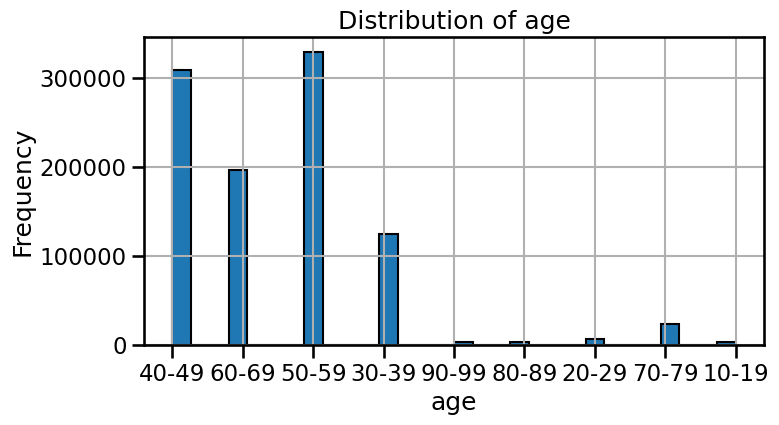

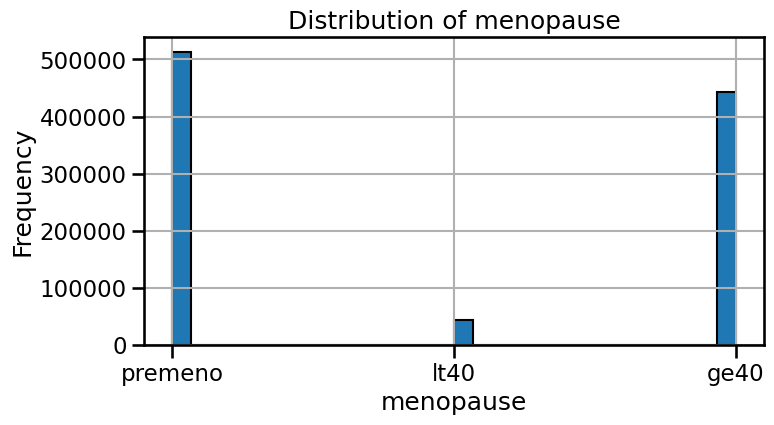

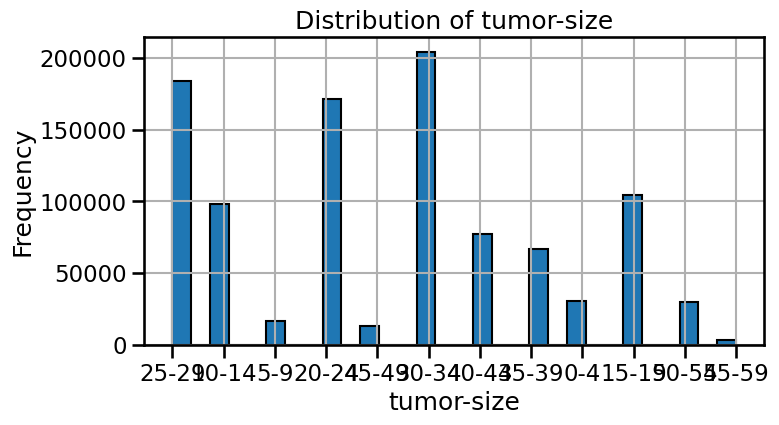

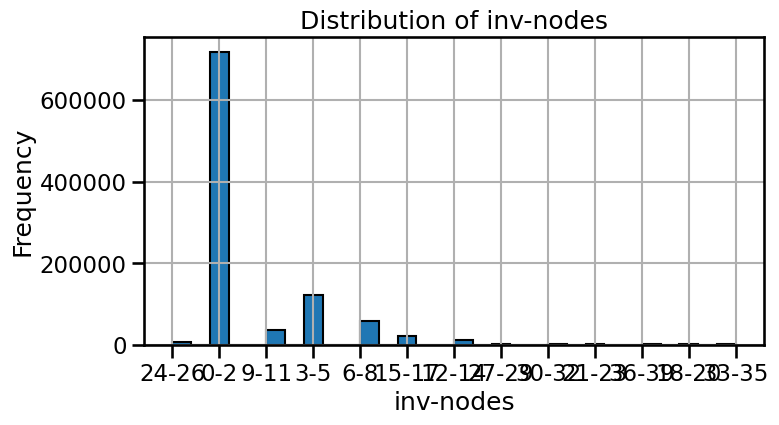

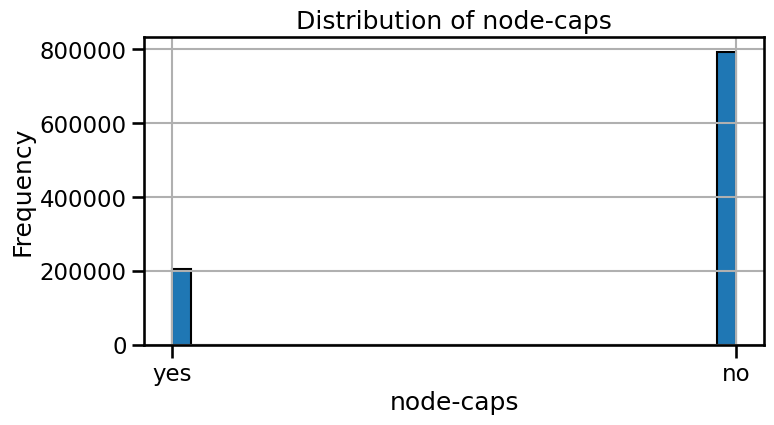

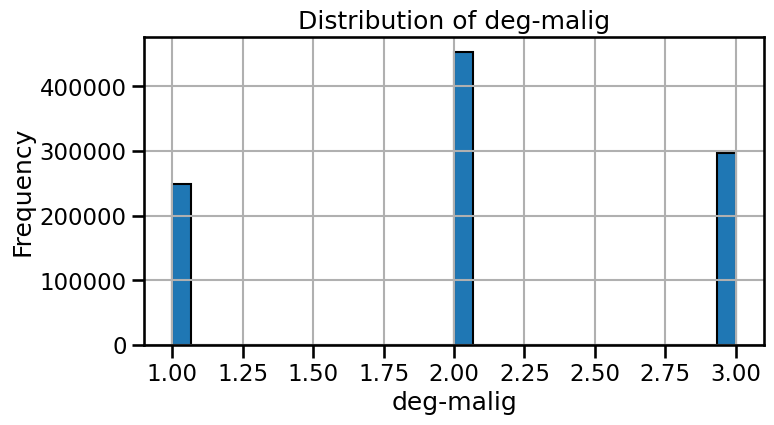

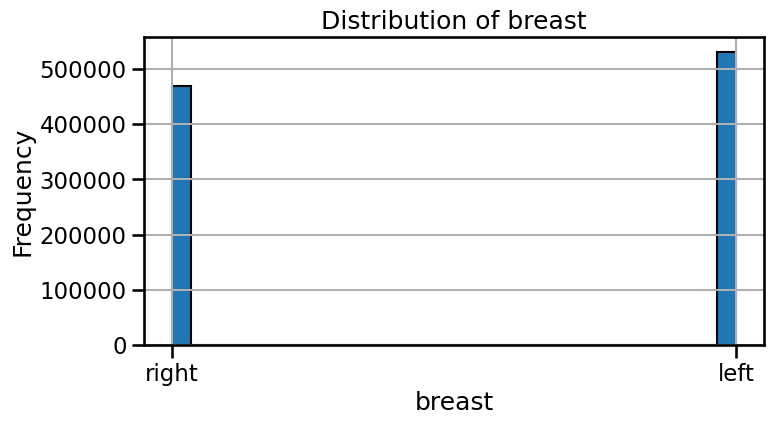

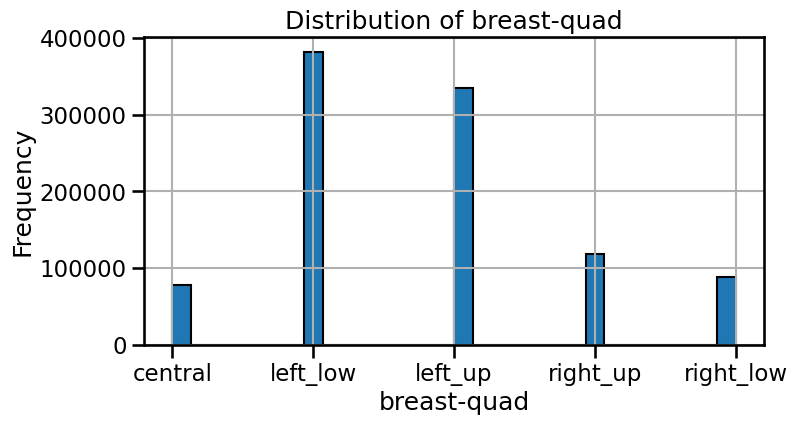

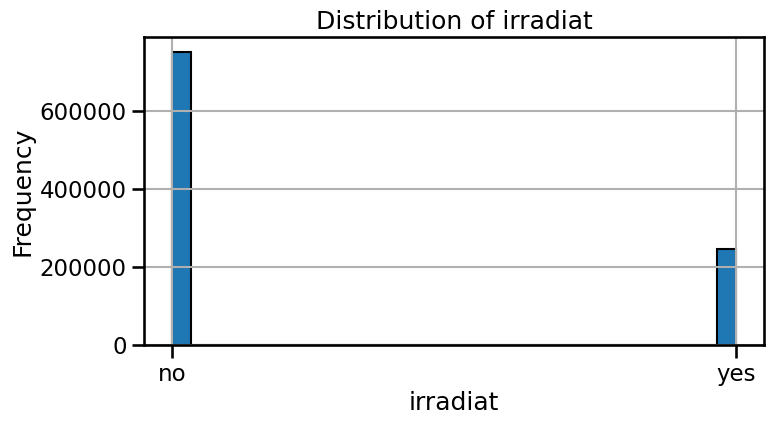

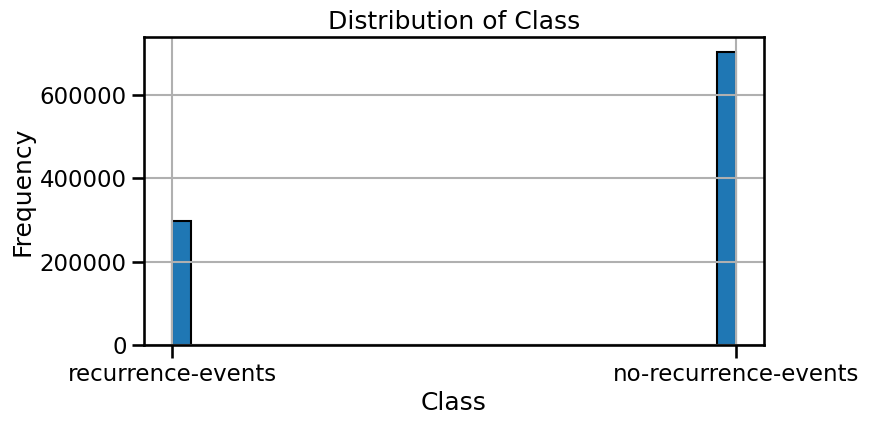

In [205]:
for column in cancer_breast.select_dtypes(include=['object', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    cancer_breast[column].hist(bins=30, edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [206]:
target_name = 'breast-quad'
data, target = cancer_breast.drop(columns=target_name), cancer_breast[target_name]

Nous souhaitons travailler sur le degrès de malignité et de récurrence d'un cancer. Ce dernier est en type String donc nous devons le changer en int. Pour se faire nous allons utiliser la fonction get_dummies.

In [207]:
data['Class']=data['Class'].replace({'no-recurrence-events':0, 'recurrence-events':1})

<ipython-input-207-5251a0bab7ac>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Class']=data['Class'].replace({'no-recurrence-events':0, 'recurrence-events':1})


In [208]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data[['deg-malig', 'Class']])

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data[['deg-malig', 'Class']])

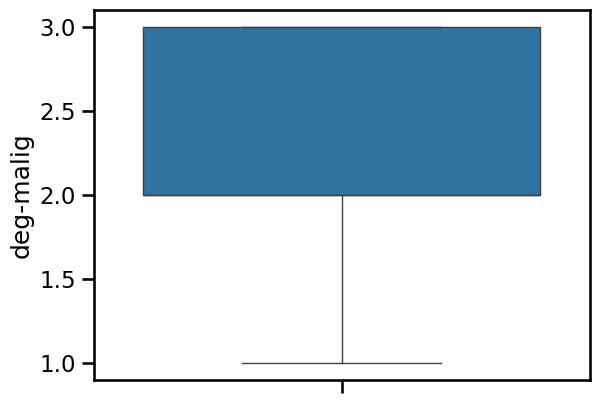

In [209]:
import numpy as np
import seaborn as sns

sns.boxplot(data['deg-malig'])
plt.show()

Q1 = data['deg-malig'].quantile(0.25)
Q3 = data['deg-malig'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

data['deg-malig'] = np.where(data['deg-malig'] < lower_limit, lower_limit, data['deg-malig'])
data['deg-malig'] = np.where(data['deg-malig'] > upper_limit, upper_limit, data['deg-malig'])


La colonne 'age' est de type String. Nous désirons travailler dessus et nous l'avons changé pour prendre en compte l'âge des patients.
Ainsi, la catégorie en 10 et 19 ans devient 10 ans, et ainsi de suite.


In [210]:
data['age'] = data['age'].str.split('-').str[0].astype(int)

In [211]:
data['tumor-size'] = data['tumor-size'].str.split('-').str[0].astype(int)

age
50    329377
40    308885
60    196058
30    124910
70     23958
20      6746
80      3408
10      3374
90      3284
Name: count, dtype: int64


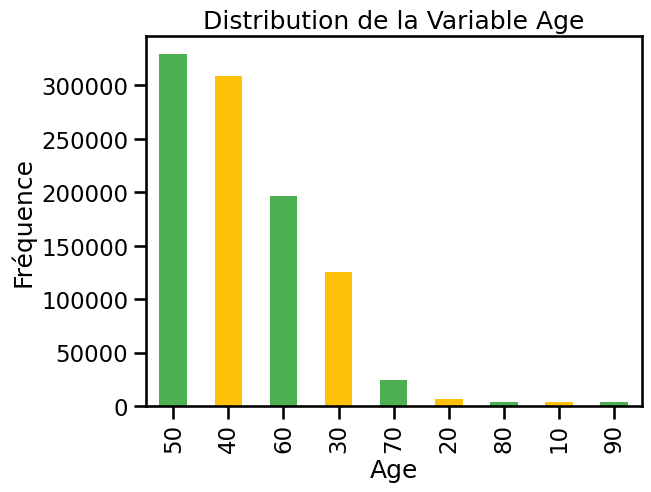

age
50    0.329377
40    0.308885
60    0.196058
30    0.124910
70    0.023958
20    0.006746
80    0.003408
10    0.003374
90    0.003284
Name: proportion, dtype: float64


In [212]:
import pandas as pd
import matplotlib.pyplot as plt

data_age = pd.DataFrame({'age': data['age']})

target_counts = data_age['age'].value_counts()

print(target_counts)

target_counts.plot(kind='bar', color=['#4CAF50', '#FFC107'])
plt.title('Distribution de la Variable Age')
plt.xlabel('Age')
plt.ylabel('Fréquence')
plt.show()

class_proportions = data['age'].value_counts(normalize=True)

print(class_proportions)


Nous pouvons observer que la fréquence d'apparition d'un cancer selon l'âge n'est pas également réparti.
Les plus hauts pourcentages sont chez les personnes ayant entre 40 et 50 ans

Nous allons voir comment sont distribués les features que nous souhaitons analyser

In [221]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

features = ['age', 'deg-malig', 'Class','tumor-size']
pipeline = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
age_target = data['age']
data2 = data.drop(columns=['menopause','inv-nodes','node-caps','breast','irradiat'])
cv_results = cross_validate(pipeline, data2, age_target, cv=10, return_estimator=True)
print(cv_results)

{'fit_time': array([0.30616593, 0.18797922, 0.17094564, 0.16120625, 0.1647892 ,
       0.16234684, 0.16212988, 0.17451811, 0.15856719, 0.15987635]), 'score_time': array([0.00885725, 0.00818348, 0.00802064, 0.00800753, 0.00855303,
       0.00788736, 0.00810242, 0.00848055, 0.00810075, 0.00800061]), 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]), Pip

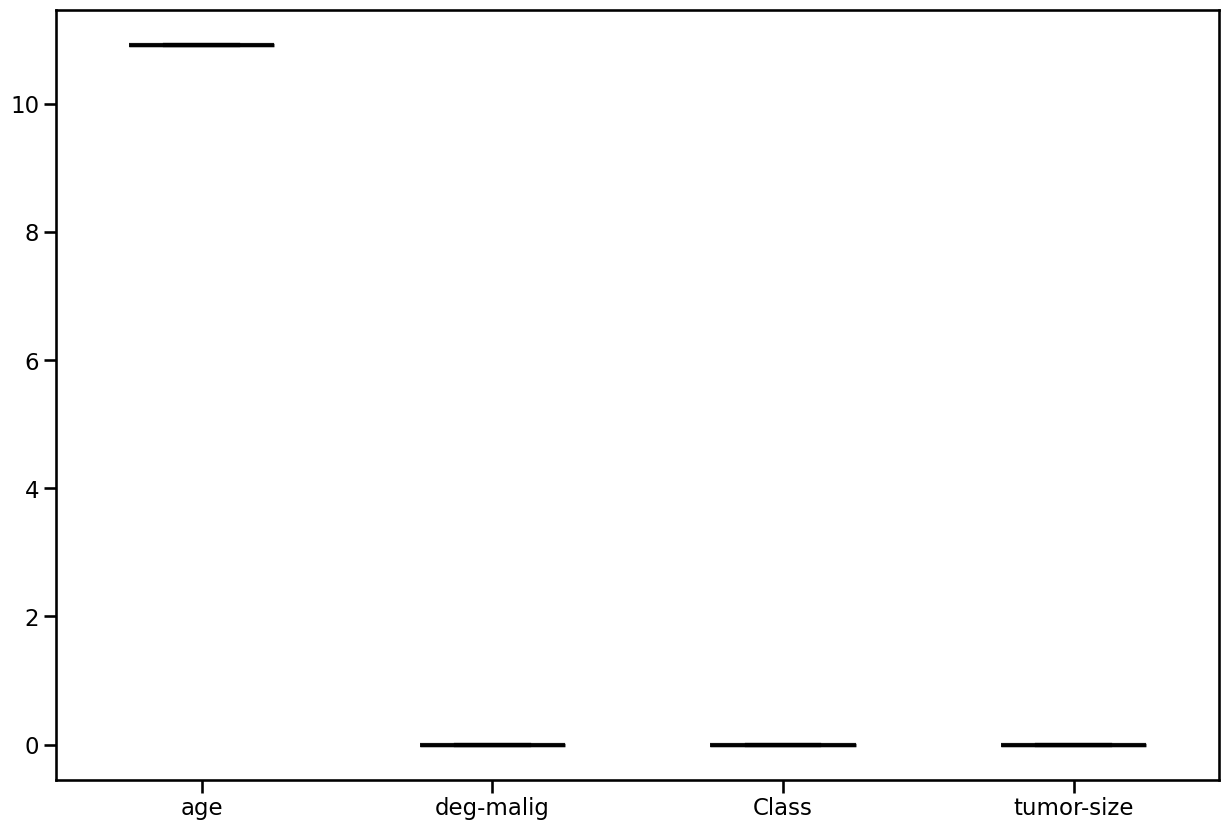

In [222]:

[max(est[-1].coef_) for est in cv_results['estimator']]


coefs = [pipeline[-1].coef_ for pipeline in cv_results["estimator"]]
coefs = pd.DataFrame(coefs, columns=features)
coefs.describe().loc[["min", "max"]]

_, ax = plt.subplots(figsize=(15, 10))
_ = coefs.plot.box(**boxplot_property, ax=ax)

Nous avons essayé de réaliser une régression sur les trois features qui nous intéressent. N'ayant pas pu continuer, nous préférons utiliser un Precision and Recall entre l'âge et le fait d'une rechute du patient.

In [215]:
y_true = data['Class']
y_pred = (data['age'] >= 40).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Précision :", precision)
print("Faux positifs :", recall)

Précision : 0.2803403586251546
Faux positifs : 0.8159648963412377


Pour les patients ayant plus de 40 ans, seulement 28% ont eu une rechute. A contrario, environ 81% des patients de plus de 40 ans n'ont pas eu de rechute

In [216]:
y_true = data['Class']
y_pred = (data['tumor-size'] >= 40 ).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Précision :", precision)
print("Faux positifs :", recall)

Précision : 0.31606962562093616
Faux positifs : 0.13167573533618013


In [217]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
print("F1 score :", f1)

F1 score : 0.1859034353012718


Au vue des résultats, l'âge, al taille de la tumeur et le degrès de malignité ne sont pas des critères suffisants pour expliquer la rechute d'un patient

In [218]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

np.random.seed(42)
data_test = pd.DataFrame({
    'age': np.random.randint(20, 80, 100000),
    'deg-malig': np.random.choice([1,2,3]),
    'tumor-size'  : np.random.randint(20, 100, 100000),
    'Class': np.random.choice([0, 1], size=100000, p=[0.7, 0.3])
})

# Séparer les features (X) et la cible (y)
X = data_test.drop(columns=['Class'])
y = data_test['Class']

# Étape 1 : Diviser les données en 80% entraînement + validation et 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Étape 2 : Diviser les 80% en 60% entraînement et 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Vérifier les proportions
print(f"Entraînement: {len(X_train)} échantillons")
print(f"Validation: {len(X_val)} échantillons")
print(f"Test: {len(X_test)} échantillons")


Entraînement: 60000 échantillons
Validation: 20000 échantillons
Test: 20000 échantillons


In [219]:
y_true = data_test['Class']
y_pred = (data_test['deg-malig'] >= 2).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Pour le degrès de malignité")
print("Précision :", precision)
print("Faux positifs :", recall)

y_true = data_test['Class']
y_pred = (data_test['age'] >= 40).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Pour l'age du patient")
print("Précision :", precision)
print("Faux positifs :", recall)

y_true = data_test['Class']
y_pred = (data_test['tumor-size'] >= 40).astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Pour la taille de la tumeur")
print("Précision :", precision)
print("Faux positifs :", recall)

Pour le degrès de malignité
Précision : 0.30279
Faux positifs : 1.0
Pour l'age du patient
Précision : 0.30119273880965564
Faux positifs : 0.6646850952805575
Pour la taille de la tumeur
Précision : 0.3025923897800275
Faux positifs : 0.7482413553948281


Avec les données de test, nous retrouvons la même chose que sur les données originales. Seule, chaque catégorie n'est pas suffisante.

In [223]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


data_test = pd.DataFrame({
    'age': np.random.randint(20, 80, 100000),
    'deg-malig': np.random.choice([1,2,3]),
    'tumor-size'  : np.random.randint(20, 100, 100000),
    'Class': np.random.choice([0, 1], size=100000, p=[0.7, 0.3])
})

# Séparer les features et la cible
X = data2.drop(columns=['Class'])
y = data2['Class']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler()),                # Normalisation
    ('classifier', RandomForestClassifier())     # Modèle
])

# Entraîner le pipeline
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
print("Accuracy :", accuracy_score(y_test, y_pred))


Accuracy : 0.744405


Avec les données de test et de validation, nous trouvons un score d'acquité assez élevé de 75%
Ensemble, nous pouvons considérer que les features choisies sont intéressantes. Mais, il peut être intéressant d'utiliser d'autres métriques.
